In [90]:
import string
import numpy as np
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

import seaborn as sb

In [101]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/labeledEmails.csv')

spam_emails = df[df['label'] == 1]
ham_emails = df[df['label'] == 0]

spams = spam_emails.sample(n=3000, random_state=42)
hams = ham_emails.sample(n=3000, random_state=42)

df = pd.concat([spams, hams])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

In [103]:
df['charCount'] = df['text'].apply(len)
df['wordCount'] = df['text'].apply(lambda x : len(nltk.word_tokenize(x)))
df['sentCount'] = df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))

In [104]:
df.describe()

,label,charCount,wordCount,sentCount
count,600.000000,600.000000,600.000000,600.000000
mean,0.500000,1673.338333,287.803333,8.471667
std,0.500417,2632.022618,475.333252,28.705619
min,0.000000,11.000000,2.000000,1.000000
25%,0.000000,455.750000,79.000000,1.000000
50%,0.500000,970.000000,163.000000,1.000000
75%,1.000000,2021.000000,327.250000,5.000000
max,1.000000,28702.000000,6118.000000,436.000000


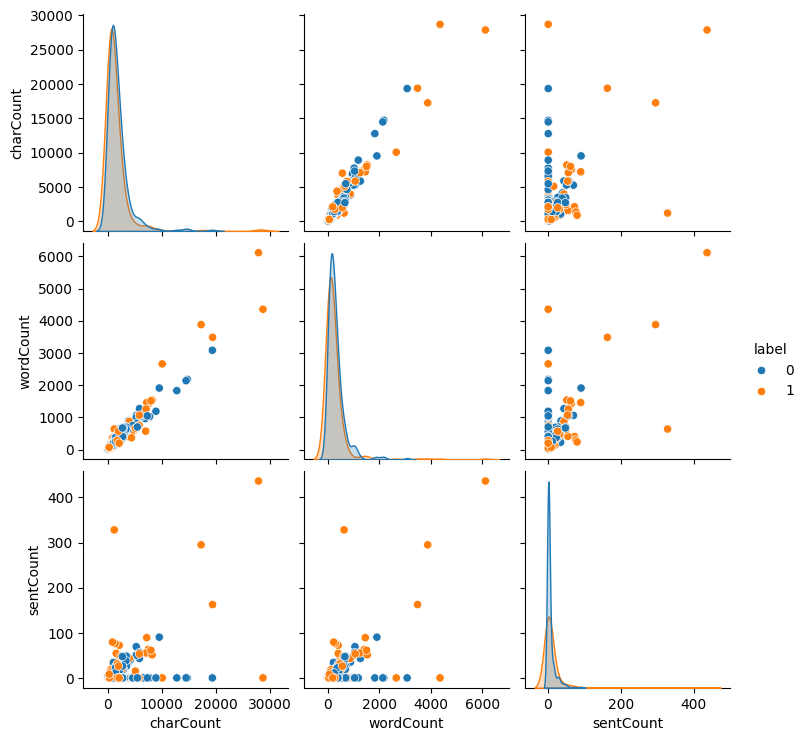

In [105]:
sb.pairplot(df, hue='label')

In [106]:
ps = PorterStemmer()

In [107]:
def processText(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]

    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords and token not in string.punctuation]

    tokens = [ps.stem(token) for token in tokens]

    return ' '.join(tokens)

In [108]:
df['processedText'] = df['text'].apply(processText)

In [88]:
cv = CountVectorizer()
X = cv.fit_transform(df['processedText']).toarray()
y = df['label'].values

In [83]:
X.shape

(5000, 48419)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True)

In [117]:
class GaussianNaiveBayes:
    def __init__(self, epsilon=1e-9):
        self.epsilon = epsilon

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0) + self.epsilon
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-(x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [111]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self._class_counts = np.zeros(n_classes, dtype=np.float64)
        self._feature_counts = np.zeros((n_classes, n_features), dtype=np.float64)
        self._class_log_priors = np.zeros(n_classes, dtype=np.float64)
        self._feature_log_probs = np.zeros((n_classes, n_features), dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._class_counts[idx] = X_c.shape[0]
            self._feature_counts[idx, :] = X_c.sum(axis=0) + self.alpha
            self._class_log_priors[idx] = np.log(self._class_counts[idx] / n_samples)

        self._feature_log_probs = np.log(self._feature_counts / self._feature_counts.sum(axis=1, keepdims=True))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        log_posteriors = []

        for idx, c in enumerate(self._classes):
            log_prior = self._class_log_priors[idx]
            log_likelihood = np.sum(x * self._feature_log_probs[idx, :])
            log_posterior = log_prior + log_likelihood
            log_posteriors.append(log_posterior)

        return self._classes[np.argmax(log_posteriors)]

In [119]:
gnb = GaussianNaiveBayes()
mnb = MultinomialNaiveBayes()

In [120]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(precision_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(accuracy_score(y_test, y_pred1))

<ipython-input-117-a7880ee3303c>:29: RuntimeWarning: divide by zero encountered in log
  class_conditional = np.sum(np.log(self._pdf(idx, x)))


0.9661016949152542
[[509   2]
 [432  57]]
0.566


In [121]:
mnb.fit(X_train, y_train)
y_pred1 = mnb.predict(X_test)
print(precision_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(accuracy_score(y_test, y_pred1))

0.9832985386221295
[[503   8]
 [ 18 471]]
0.974
